In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = table[0]['Symbol'].to_list()
sp500_list = [s.replace('.', '-') for s in sp500_list]
len(sp500_list)

503

In [4]:
table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')
nasdaq_list = table[4]['Ticker'].to_list()
nasdaq_list = [s.replace('.', '-') for s in nasdaq_list]
len(nasdaq_list)

102

In [5]:
stock_pool = list(set(sp500_list).union(set(nasdaq_list)))

In [53]:
from main import get_norm_return
norm_return = get_norm_return(stock_pool, '2022-01-01', '2022-10-31', dropna=True)

[*********************100%***********************]  526 of 526 completed


In [54]:
spy = yf.download("SPY", start='2022-01-01', end='2022-10-31')

[*********************100%***********************]  1 of 1 completed


In [67]:
from main import random_portfolio
# print(p[0], p[1])
best_sharpe, best_p = 0, None
for i in range(5000):
    p = random_portfolio(norm_return.columns, k_low=10, w='rand')
    initial_cap = 1e6
    portfolio = norm_return[p[0]] * p[1] * initial_cap
    portfolio['TotalPos'] = portfolio.sum(axis=1)
    portfolio['PercentagePos'] = portfolio.TotalPos / portfolio.TotalPos.iloc[0]
    portfolio['DailyPercentageReturn'] = portfolio['TotalPos'].pct_change(1)

    # portfolio.PercentagePos.plot(label='myPortfolio')

    # (spy['Adj Close'] / spy['Adj Close'].iloc[0]).plot(label='SP500')
    # plt.legend()
    # plt.show()

    kvalue = {'D': np.sqrt(252), 'W': np.sqrt(52), 'M': np.sqrt(12)}
    sharpe = kvalue['D'] * portfolio.DailyPercentageReturn.mean() / portfolio.DailyPercentageReturn.std()

    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_p = portfolio
# sharpe

0.9484741002888158

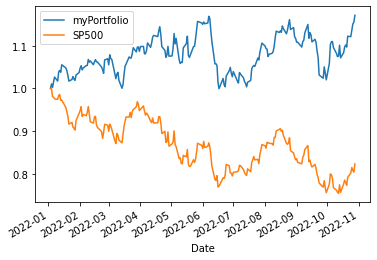

In [68]:
display(best_sharpe)
best_p.PercentagePos.plot(label='myPortfolio')
(spy['Adj Close'] / spy['Adj Close'].iloc[0]).plot(label='SP500')
plt.legend()
plt.show()

In [69]:
best_p.columns

Index(['SNA', 'DRI', 'WBD', 'EIX', 'LVS', 'JBHT', 'MRO', 'APA', 'PM', 'HES',
       'PAYC', 'WRK', 'CI', 'LW', 'CPB', 'LNT', 'PFE', 'DIS', 'WMB', 'CTVA',
       'MDLZ', 'TotalPos', 'PercentagePos', 'DailyPercentageReturn'],
      dtype='object')